# How to fit data

In lots of times, we need to fit our data with different lineshapes. We implenment the fitting function using lmfit package. Here is a link to the official document of lmfit

https://lmfit.github.io/lmfit-py/

Fortunately, one don't need to read and understand everything to do a fit, but just a few concepts and tools

- Models. An object of Model() class in lmfit package is a slover for certain cureve. The lmfit package and we alread defined lots of models, and it is also possible and easy to define a new model for a new curve.
- Parameters. The fit is usually sensitive to the initial values and boundary conditions. Parameters() is a class, which hold all these information for a fit.
- Fit Reasult. In the lmfit package, the reulst of fit is also a class, but we implenment some functions to translate it into numbers.

Let's start again with some examples.

## Load some example data

### Import supporting packages

In [1]:
# Set the system path for importing packages
# This is just because I put all example scripts in another folder
# You DO NOT need to do this 
# -------------- You do NOT need following part --------------
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
# -------------- You do NOT need above part --------------

import copy
import glob
from datetime import datetime

# The package for data structure
import xarray as xr
import pandas as pd
import numpy as np

# The packages for working with uncertainties
from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

# The package for plotting
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 # Set the global font size

# -------------- The modules written by us --------------

# The packages for read data
from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file

# The packages for data analysis
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

# Add errorbar plot to xarray package
from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

### Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:65093' processes=6 threads=60, memory=55.88 GiB>

### Set the path for different cameras

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

# give a short name to each path (or let's say each camera)
dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}

### Set global path for experiment

In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/17'# get_date()

### Load shot 0058

In [5]:
shotNum = "0058"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0] # range(len(groupList)) # uncommont to load data for all three cameras
}
dataSet = dataSetDict["camera_0"]

dataSet = swap_xy(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet

<xarray.Dataset>
Dimensions:           (runs: 5, truncation_value: 11, y: 1200, x: 1920)
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Dimensions without coordinates: y, x
Data variables:
    atoms             (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    background        (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    dark              (runs, truncation_value, y, x) uint16 dask.array<chunksize=(5, 11, 1200, 1920), meta=np.ndarray>
    shotNum           (runs, truncation_value) <U2 dask.array<chunksize=(5, 11), meta=np.ndarray>
Attributes: (12/100)
    TOF_free:                          0.02
    abs_img_freq:                      110.866
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    z_offset:                          0.195
    z_offset_img:                      0.195
    truncation_value:                  [0.8  0.83 0.85 0.87 0.89 0.91 0.93 0....
    runs:                              [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1...
    scanAxis:                          ['runs' 'truncation_value']
    scanAxisLength:                    [55. 55.]

### Calculate the absorption imaging

In [6]:
imageAnalyser = ImageAnalyser()

imageAnalyser.center = (960, 875)
imageAnalyser.span = (300, 300)
imageAnalyser.fraction = (0.1, 0.1)

dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
dataSet_cropOD

<xarray.DataArray 'OD' (runs: 5, truncation_value: 11, y: 300, x: 300)>
array([[[[ 0.10089884,  0.0696463 ,  0.05767011, ...,  0.01963588,
          -0.0650863 , -0.00446167],
         [ 0.10342729,  0.04260584,  0.02118076, ...,  0.11194868,
           0.00723437, -0.0801735 ],
         [ 0.00780842,  0.00827735, -0.02827232, ..., -0.02693453,
          -0.00446167,  0.0622297 ],
         ...,
         [-0.1117072 , -0.0575715 , -0.03836323, ..., -0.05152918,
          -0.02529576,  0.00751452],
         [ 0.12183205,  0.03190597,  0.01355683, ..., -0.02573907,
          -0.05682966, -0.00446167],
         [ 0.03475904,  0.0325796 ,  0.07721636, ...,  0.02662891,
          -0.05738408,  0.00751452]],

        [[ 0.05613155, -0.10849043,  0.05082337, ...,  0.09902547,
           0.01710835,  0.03692657],
         [-0.08110418, -0.09280022,  0.01710835, ..., -0.04168176,
          -0.15458948,  0.00483825],
         [-0.07212279, -0.00743184, -0.05653069, ..., -0.18356235,
          -0.01621516, -0.07006305],
...
         [ 0.15678264,  0.09630046,  0.1255301 , ..., -0.00355249,
           0.01855798, -0.00499196],
         [ 0.00774706, -0.07926432,  0.0260962 , ..., -0.01447608,
          -0.03527032,  0.04126975],
         [-0.01094507, -0.16745703, -0.0624572 , ...,  0.07159853,
           0.01769739, -0.06124581]],

        [[ 0.05950001,  0.0086876 , -0.02921711, ...,  0.04073558,
          -0.00421581, -0.04723319],
         [-0.0555091 , -0.11475768, -0.05360856, ..., -0.01551536,
           0.03087551, -0.00421581],
         [ 0.03352452, -0.01663833,  0.01931469, ...,  0.01752418,
          -0.02504989,  0.04815218],
         ...,
         [ 0.03087551,  0.05294261, -0.13050953, ..., -0.0277463 ,
          -0.05020092, -0.04014782],
         [ 0.03352452, -0.04422114, -0.06030527, ..., -0.06009626,
          -0.03467501,  0.09642772],
         [-0.04125708,  0.01447633,  0.07129175, ...,  0.06247557,
          -0.05947848, -0.01538911]]]])
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Dimensions without coordinates: y, x
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              810
    x_end:                1110
    y_end:                1025
    y_start:              725
    x_center:             960
    y_center:             875
    x_span:               300
    y_span:               300

### Plot the OD images

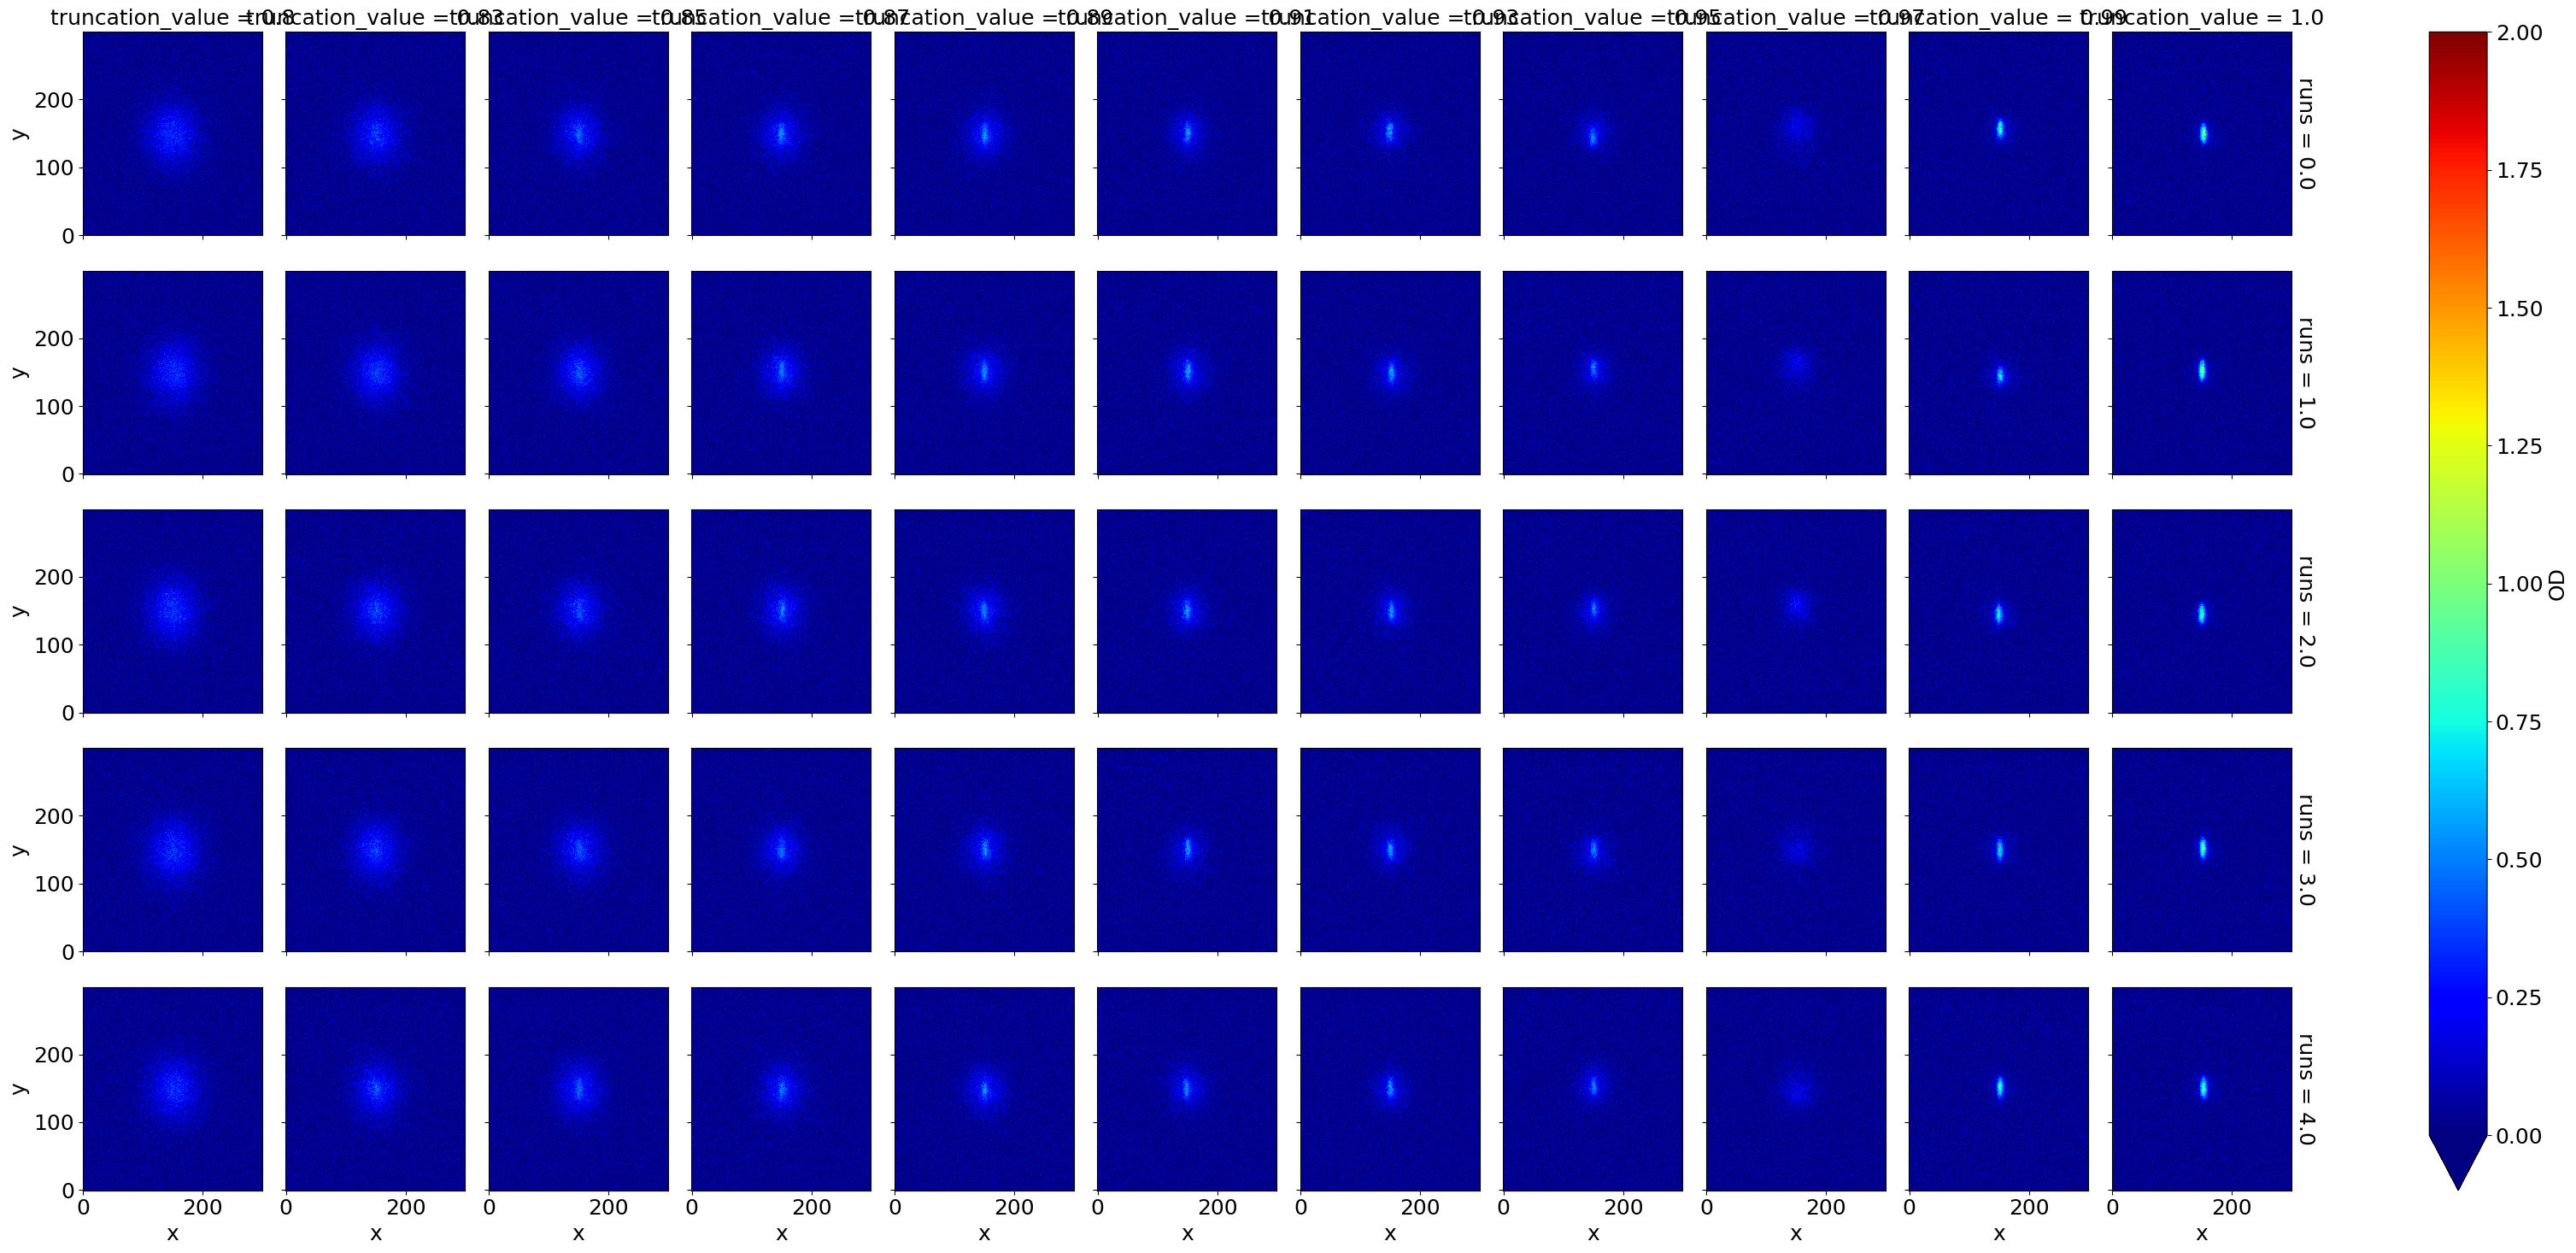

In [7]:
# first get the scan axes
scanAxis = get_scanAxis(dataSet)

# Name_of_varibale.plot.name_of_plot_type(col=scanAxis[0], row=scanAxis[1], **kwargs)
# The name of the plot type has the same name as it in the matplotlib package
# The **kwargs to adjust the plot also as same as the matplotlib package
dataSet_cropOD.plot.pcolormesh(col=scanAxis[0], row=scanAxis[1], cmap='jet', vmin=0, vmax=2)

plt.show()

Let us first do a 2D-two-peak gaussian fit to find the center and waist of the cloud.

## Creat an object of fit analyser 

The idea is to package all fitting related analysis funciton into a clasee, the 'FitAnalyser'. The advantage is that it record our last settings, i.e. the model of the fit, and thus we don't need to set it again.

Therefore, first we need to create an object of the 'FitAnalyser' class.

In [8]:
from Analyser.FitAnalyser import TwoGaussian2dModel


# The fit model
# fitModel = DensityProfileBEC2dModel()
fitModel = TwoGaussian2dModel()

fitAnalyser = FitAnalyser(fitModel, fitDim=2)

Here there is a complete list of implenmented fitting model

```
lmfit_models = {'Constant': ConstantModel,
                'Complex Constant': ComplexConstantModel,
                'Linear': LinearModel,
                'Quadratic': QuadraticModel,
                'Polynomial': PolynomialModel,
                'Gaussian': GaussianModel,
                'Gaussian-2D': Gaussian2dModel,
                'Lorentzian': LorentzianModel,
                'Split-Lorentzian': SplitLorentzianModel,
                'Voigt': VoigtModel,
                'PseudoVoigt': PseudoVoigtModel,
                'Moffat': MoffatModel,
                'Pearson7': Pearson7Model,
                'StudentsT': StudentsTModel,
                'Breit-Wigner': BreitWignerModel,
                'Log-Normal': LognormalModel,
                'Damped Oscillator': DampedOscillatorModel,
                'Damped Harmonic Oscillator': DampedHarmonicOscillatorModel,
                'Exponential Gaussian': ExponentialGaussianModel,
                'Skewed Gaussian': SkewedGaussianModel,
                'Skewed Voigt': SkewedVoigtModel,
                'Thermal Distribution': ThermalDistributionModel,
                'Doniach': DoniachModel,
                'Power Law': PowerLawModel,
                'Exponential': ExponentialModel,
                'Step': StepModel,
                'Rectangle': RectangleModel,
                'Expression': ExpressionModel,
                'Gaussian With Offset':GaussianWithOffsetModel,
                'Lorentzian With Offset':LorentzianWithOffsetModel,
                'Expansion':ExpansionModel,
                'Damping Oscillation Model':DampingOscillationModel,
                'Two Gaussian-2D':TwoGaussian2dModel,
                'Thomas Fermi-2D': ThomasFermi2dModel,
                'Density Profile of BEC-2D': DensityProfileBEC2dModel,
                'Polylog2-2D': polylog2_2d, 
                }
```

## Set initial values and bondaries

There are two ways to set the parameters of a fit:
- Use the guession function of the model, which guess the initial values from the data
- Manually set the parameters

### Manually set the parameters 

First we need to create an object of the parameters

In [9]:
params = fitAnalyser.fitModel.make_params()

Then we can use a function to generate a template.

In [10]:
fitAnalyser.print_params_set_template()

params.add(name="A_amplitude", value=  1, max=np.inf, min=-np.inf, vary=True)
params.add(name="A_centerx", value=  0, max=np.inf, min=-np.inf, vary=True)
params.add(name="A_centery", value=  0, max=np.inf, min=-np.inf, vary=True)
params.add(name="A_sigmax", expr="delta + B_sigmax")
params.add(name="A_sigmay", value=  1, max=np.inf, min=-np.inf, vary=True)
params.add(name="B_amplitude", value=  1, max=np.inf, min=-np.inf, vary=True)
params.add(name="B_centerx", value=  0, max=np.inf, min=-np.inf, vary=True)
params.add(name="B_centery", value=  0, max=np.inf, min=-np.inf, vary=True)
params.add(name="B_sigmax", value=  1, max=np.inf, min=-np.inf, vary=True)
params.add(name="B_sigmay", value=  1, max=np.inf, min=-np.inf, vary=True)
params.add(name="delta", value= -1, max=  0, min=-np.inf, vary=True)


### Use the guess function

In [11]:
# The default name of x axis and y axis are 'x' and 'y', 
# if not please use the argument 'x' and 'y' to specify the names or the values.
# The 'guess_kwargs' is the additional key words sent to guess() funcition in the model
params = fitAnalyser.guess(dataSet_cropOD, guess_kwargs=dict(pureBECThreshold=0.5), dask="parallelized")

Here the data are too large, we only show the parameters for the first shot

In [12]:
params[0, 0].item()

Parameters([('A_amplitude', <Parameter 'A_amplitude', value=1954.6248098806716, bounds=[-inf:inf]>), ('A_centerx', <Parameter 'A_centerx', value=144, bounds=[-inf:inf]>), ('A_centery', <Parameter 'A_centery', value=136, bounds=[-inf:inf]>), ('A_sigmax', <Parameter 'A_sigmax', value=48.833333333333336, bounds=[-inf:inf], expr='delta + B_sigmax'>), ('A_sigmay', <Parameter 'A_sigmay', value=49.833333333333336, bounds=[0.0:inf]>), ('B_amplitude', <Parameter 'B_amplitude', value=1954.6248098806716, bounds=[-inf:inf]>), ('B_centerx', <Parameter 'B_centerx', value=144, bounds=[-inf:inf]>), ('B_centery', <Parameter 'B_centery', value=136, bounds=[-inf:inf]>), ('B_sigmax', <Parameter 'B_sigmax', value=49.833333333333336, bounds=[0.0:inf]>), ('B_sigmay', <Parameter 'B_sigmay', value=49.833333333333336, bounds=[0.0:inf]>), ('delta', <Parameter 'delta', value=-1, bounds=[-inf:0]>)])

## Do the fit

`As we discussed before, the parallel computing needs chunks. And now there is no chunk! In order to enable the parallel computing, we have to rechunk our data.`

In [13]:
dataSet_cropOD = dataSet_cropOD.chunk((1, 1, 300, 300))
params = params.chunk((1, 1))

In [14]:
dataSet_cropOD

<xarray.DataArray 'OD' (runs: 5, truncation_value: 11, y: 300, x: 300)>
dask.array<xarray-<this-array>, shape=(5, 11, 300, 300), dtype=float64, chunksize=(1, 1, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Dimensions without coordinates: y, x
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              810
    x_end:                1110
    y_end:                1025
    y_start:              725
    x_center:             960
    y_center:             875
    x_span:               300
    y_span:               300

In [15]:
fitResult = fitAnalyser.fit(dataSet_cropOD, params).load()

## Get the number from fit result

### Get the values

In [16]:
val = fitAnalyser.get_fit_value(fitResult)
val

<xarray.Dataset>
Dimensions:           (runs: 5, truncation_value: 11)
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Data variables:
    A_amplitude       (runs, truncation_value) float64 87.87 73.76 ... 206.3
    A_centerx         (runs, truncation_value) float64 147.4 151.4 ... 152.8
    A_centery         (runs, truncation_value) float64 151.3 147.2 ... 150.4
    A_sigmax          (runs, truncation_value) float64 15.86 9.018 ... 3.964
    A_sigmay          (runs, truncation_value) float64 19.13 13.12 ... 10.61
    B_amplitude       (runs, truncation_value) float64 1.783e+03 ... 159.9
    B_centerx         (runs, truncation_value) float64 149.8 152.0 ... 154.1
    B_centery         (runs, truncation_value) float64 147.5 148.1 ... 150.4
    B_sigmax          (runs, truncation_value) float64 32.53 31.39 ... 15.85
    B_sigmay          (runs, truncation_value) float64 33.29 32.43 ... 13.79
    delta             (runs, truncation_value) float64 -16.67 -22.38 ... -11.89
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              810
    x_end:                1110
    y_end:                1025
    y_start:              725
    x_center:             960
    y_center:             875
    x_span:               300
    y_span:               300

### Get the standard deviation

In [17]:
std = fitAnalyser.get_fit_std(fitResult)
std

<xarray.Dataset>
Dimensions:           (runs: 5, truncation_value: 11)
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Data variables:
    A_amplitude       (runs, truncation_value) float64 41.35 8.536 ... 4.752
    A_centerx         (runs, truncation_value) float64 1.373 0.4656 ... 0.0426
    A_centery         (runs, truncation_value) float64 1.829 0.7057 ... 0.1419
    A_sigmax          (runs, truncation_value) float64 2.502 0.6067 ... 0.05853
    A_sigmay          (runs, truncation_value) float64 2.561 0.8023 ... 0.139
    B_amplitude       (runs, truncation_value) float64 38.55 11.89 ... 6.328
    B_centerx         (runs, truncation_value) float64 0.271 0.2215 ... 0.5065
    B_centery         (runs, truncation_value) float64 0.3084 0.239 ... 0.5433
    B_sigmax          (runs, truncation_value) float64 0.473 0.2884 ... 0.6838
    B_sigmay          (runs, truncation_value) float64 0.4067 0.2715 ... 0.5322
    delta             (runs, truncation_value) float64 2.199 0.5443 ... 0.6551
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              810
    x_end:                1110
    y_end:                1025
    y_start:              725
    x_center:             960
    y_center:             875
    x_span:               300
    y_span:               300

### Work with uncertainties

Sometimes we will do some other calculation based on the fit result. It is always a little bit tricky to calculate the error propagation. Fortunately, there is a package provide a solution to deal with it, please have a look of the following link.

https://pythonhosted.org/uncertainties/

We can also read the fit results as a format combining the value and standard deviation, which is used in the above package. Such a format allows us to do the basic calculation with auto-calculated error propagation.

In [18]:
uval = fitAnalyser.get_fit_full_result(fitResult)
uval

<xarray.Dataset>
Dimensions:           (runs: 5, truncation_value: 11)
Coordinates:
  * runs              (runs) float64 0.0 1.0 2.0 3.0 4.0
  * truncation_value  (truncation_value) float64 0.8 0.83 0.85 ... 0.97 0.99 1.0
Data variables:
    A_amplitude       (runs, truncation_value) object (9+/-4)e+01 ... 206+/-5
    A_centerx         (runs, truncation_value) object 147.4+/-1.4 ... 152.82+...
    A_centery         (runs, truncation_value) object 151.3+/-1.8 ... 150.44+...
    A_sigmax          (runs, truncation_value) object 15.9+/-2.5 ... 3.96+/-0.06
    A_sigmay          (runs, truncation_value) object 19.1+/-2.6 ... 10.61+/-...
    B_amplitude       (runs, truncation_value) object (1.78+/-0.04)e+03 ... 1...
    B_centerx         (runs, truncation_value) object 149.77+/-0.27 ... 154.1...
    B_centery         (runs, truncation_value) object 147.45+/-0.31 ... 150.4...
    B_sigmax          (runs, truncation_value) object 32.5+/-0.5 ... 15.9+/-0.7
    B_sigmay          (runs, truncation_value) object 33.3+/-0.4 ... 13.8+/-0.5
    delta             (runs, truncation_value) object -16.7+/-2.2 ... -11.9+/...
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              810
    x_end:                1110
    y_end:                1025
    y_start:              725
    x_center:             960
    y_center:             875
    x_span:               300
    y_span:               300

## Plot the fit curve

In the most of cases, we need not only to know the fit result, but also plot the fit curve. Here we also provide a function to calculate the fit curve.

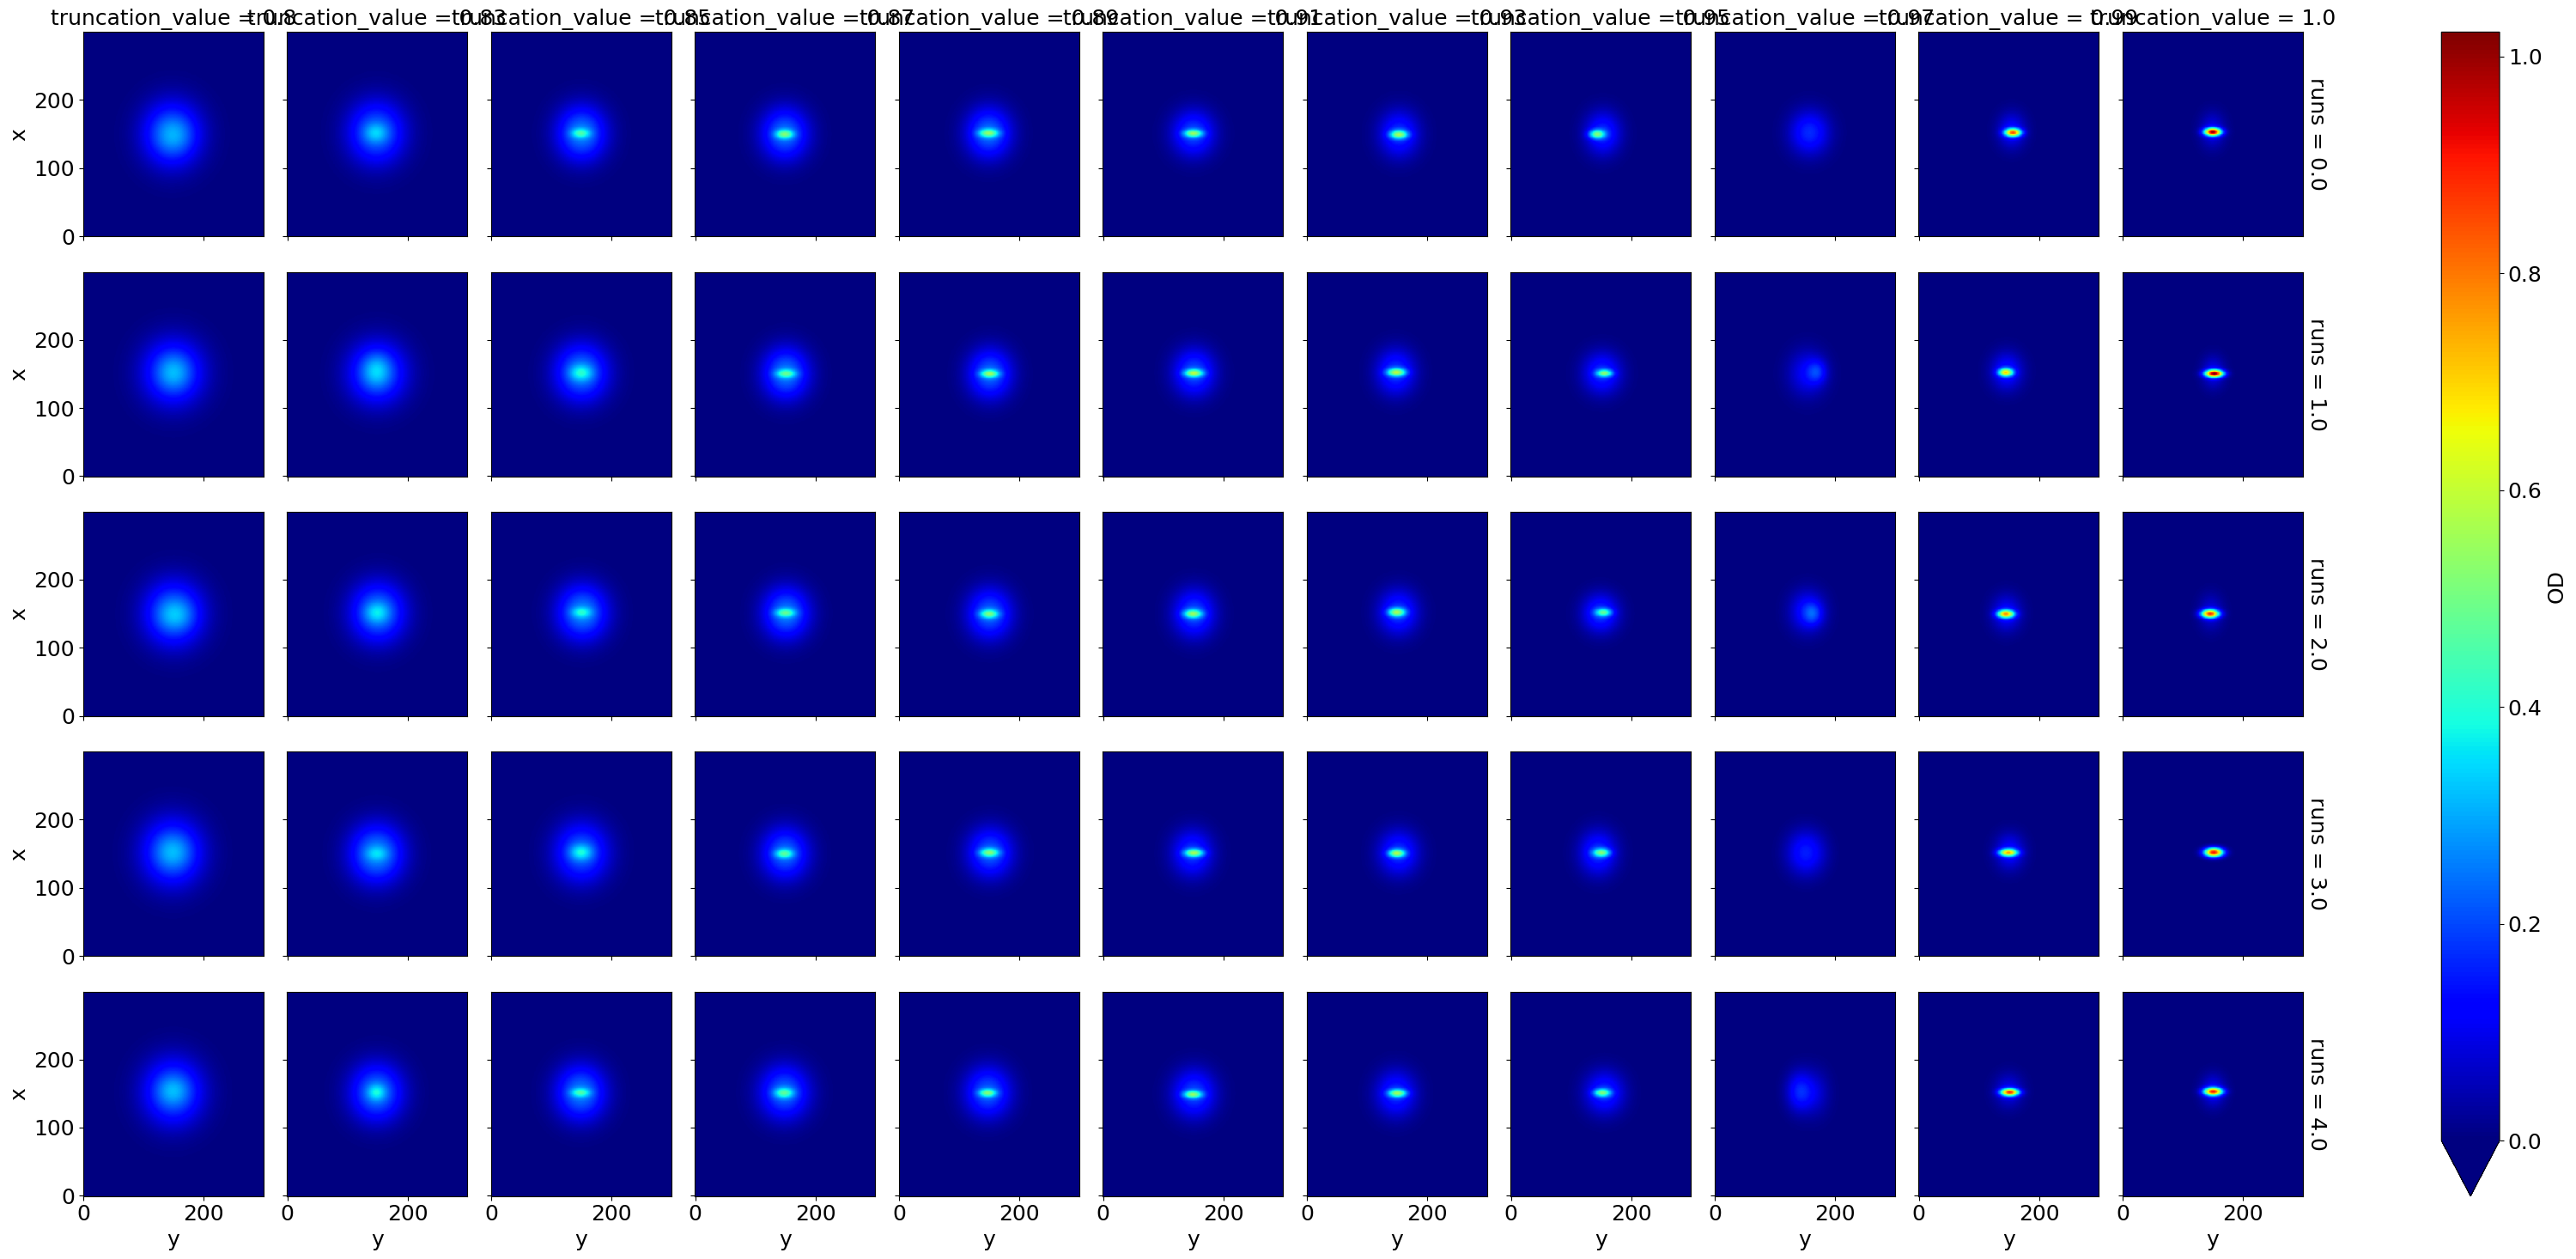

In [19]:
fitCurve = fitAnalyser.eval(fitResult, x=np.arange(300), y=np.arange(300), dask="parallelized").load()

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

Sometimes, the fit model contains two parts, i.e. the BEC part and the thermal part. People only want to plot one part of the result. In the following, there is an example for that.

f:\Jianshun\analyseScript\Analyser\FitAnalyser.py:86: RuntimeWarning: invalid value encountered in power
  res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)**(3 / 2)


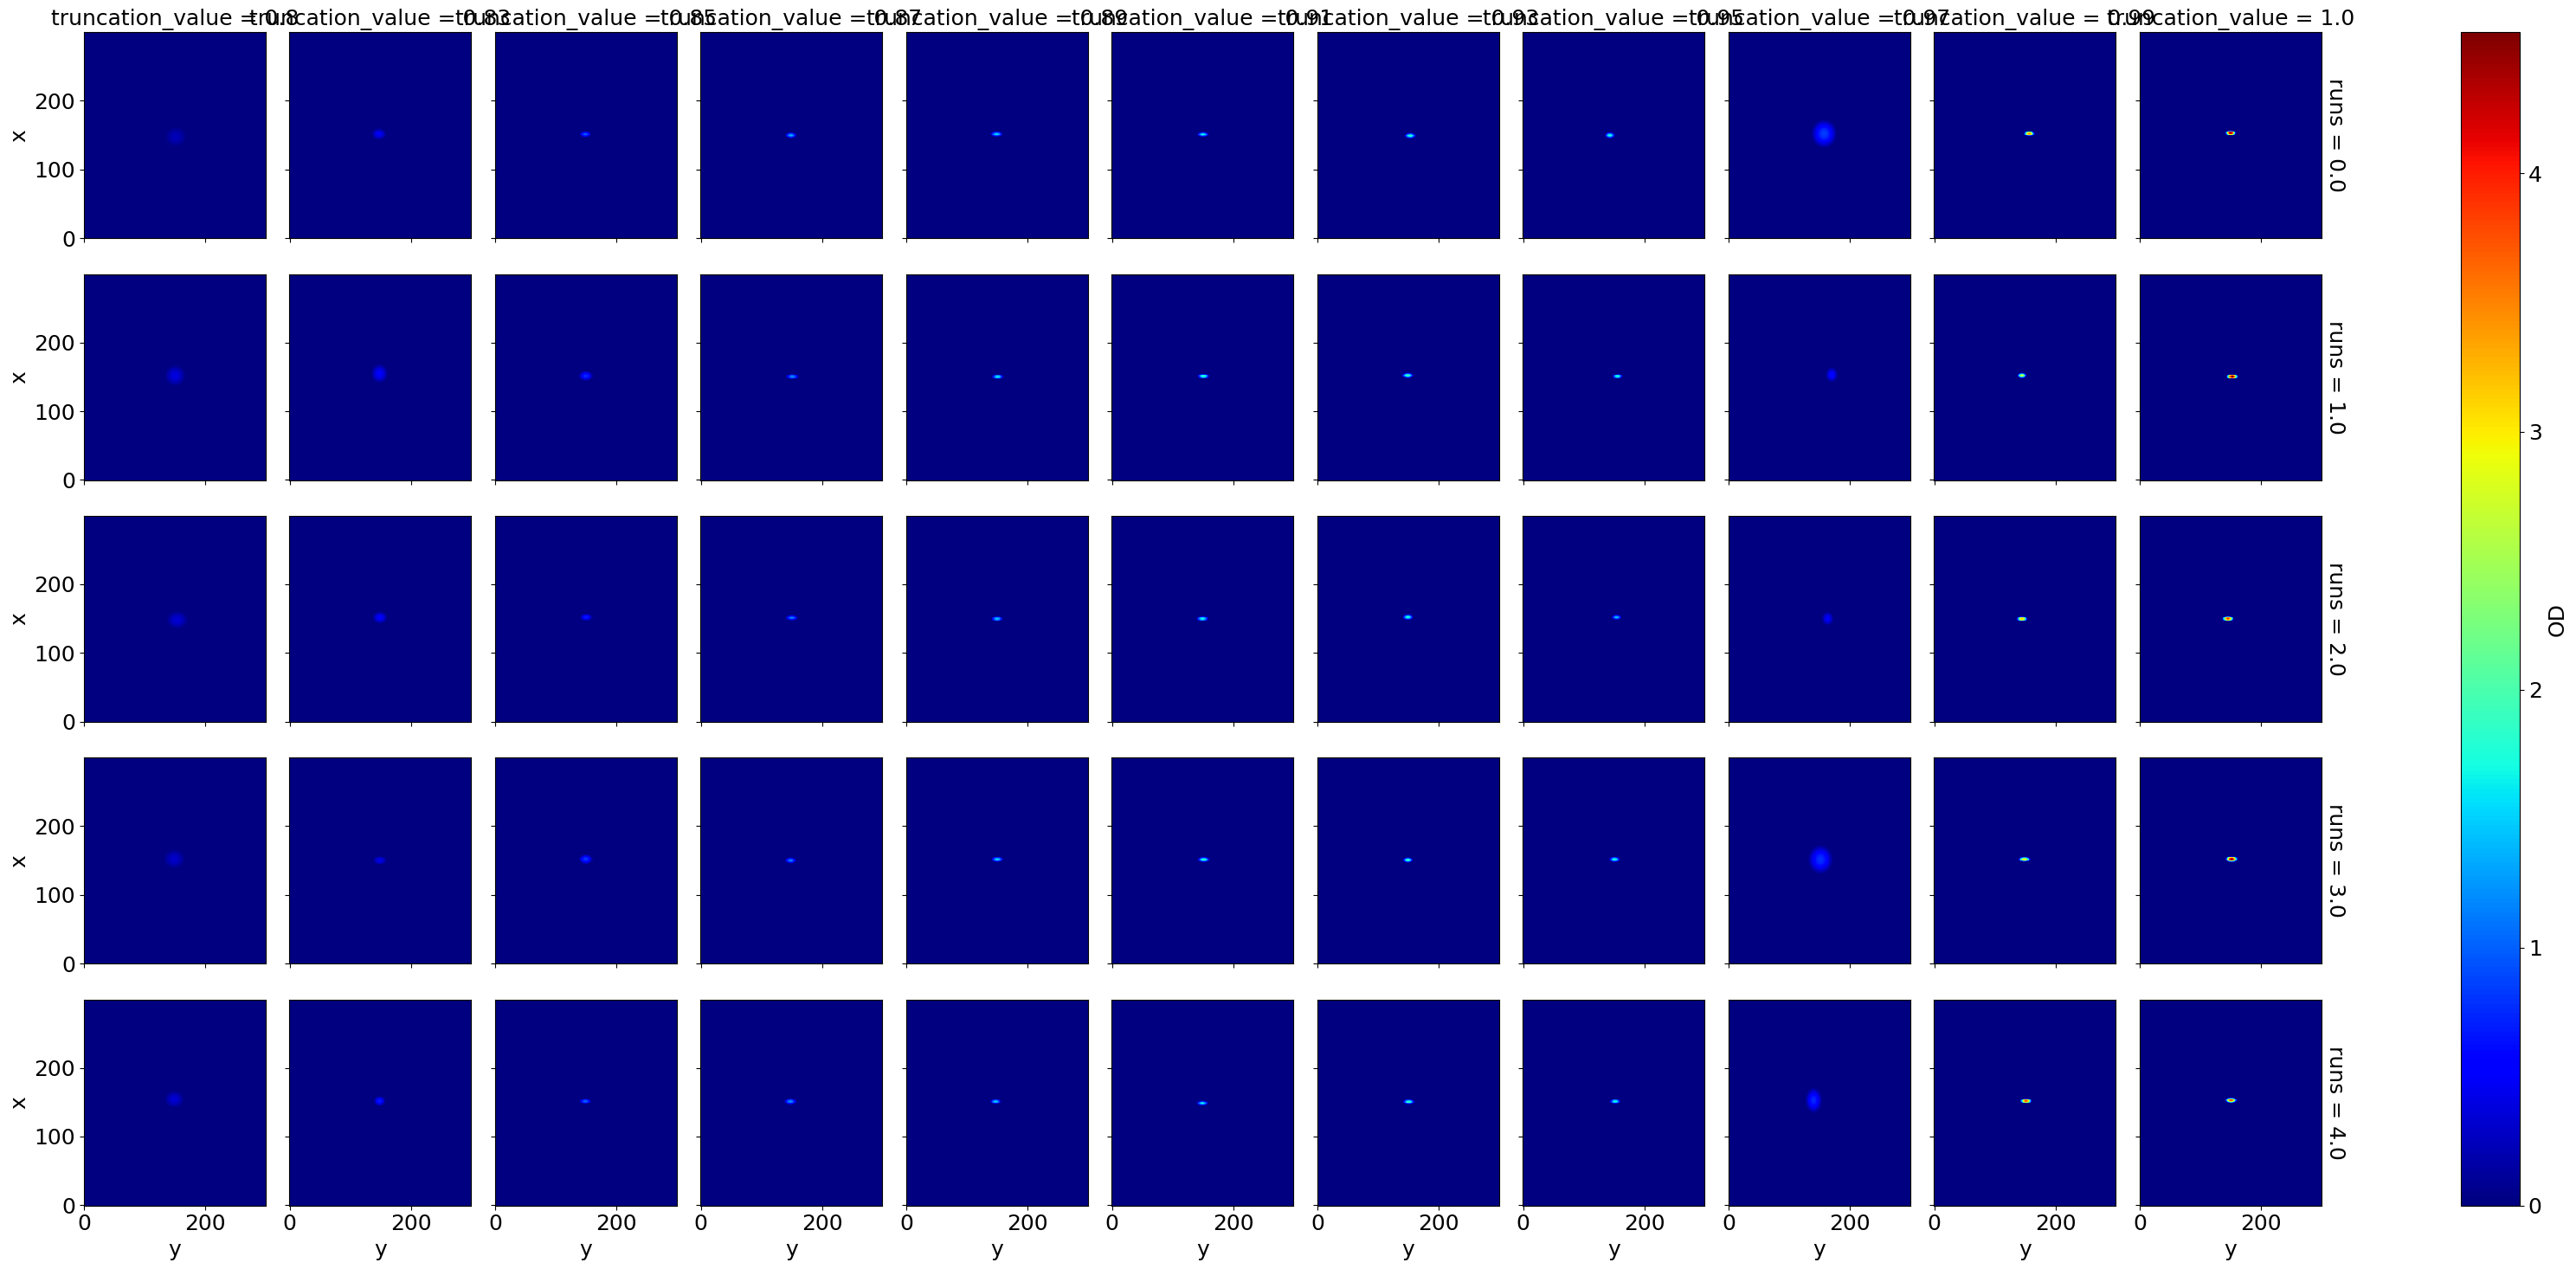

In [20]:
# Create a fit model for the BEC part with prefix string 
# making the name of parameters as same as its in the fit reuslts.
fitModel = ThomasFermi2dModel(prefix='A_')

fitAnalyser_BEC = FitAnalyser(fitModel, fitDim=2)
fitCurve = fitAnalyser_BEC.eval(fitResult, x=np.arange(300), y=np.arange(300), dask="parallelized").load()

fitCurve.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

## Creat a customized fit model

In [21]:
from Analyser.FitAnalyser import NewFitModel


def customized_function(x, a, b):
    return x * a + b

customized_fitModel = NewFitModel(customized_function)

customized_fitAnalyser = FitAnalyser(customized_fitModel, fitDim=1)

customized_fitAnalyser.print_params_set_template()

params.add(name="a", value=-inf, max=np.inf, min=-np.inf, vary=True)
params.add(name="b", value=-inf, max=np.inf, min=-np.inf, vary=True)
